# Scale-free hypergraph generation

In this notebook you will:

- Generate scale-free hypergraphs with controlled degree correlations.
- Compute size-degree distributions and compare layers.
- Visualize interaction-size effects.


## Overview

- Generate scale-free hypergraphs and compare degree distributions.
- Visualize sample structures and validate model behavior.


## Setup


In [ ]:
import matplotlib as mpl

mpl.rcParams.update({
    "figure.figsize": (6, 4),
    "figure.dpi": 120,
    "savefig.dpi": 150,
})


In [35]:
import math
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import spearmanr

from hypergraphx.generation.scale_free import scale_free_hypergraph

In [36]:
# -----------------------------
# Helpers
# -----------------------------
def iter_all_edges(hg):
    for e in hg.get_edges():
        yield tuple(e)

def edges_of_size(hg, size: int):
    edges = hg.get_edges(size=size)
    return edges

def sizes_present(hg):
    return sorted(set(hg.get_sizes()))

def nodes_present(hg):
    ns = hg.get_nodes()
    return np.array(sorted(map(int, ns)))

def degree_by_size(hg, size: int, num_nodes: int | None = None):
    """Size-specific degrees k_i^{(size)} as a numpy array of length num_nodes."""
    if num_nodes is None:
        num_nodes = int(nodes_present(hg).max()) + 1
    deg = np.zeros(num_nodes, dtype=int)
    for e in edges_of_size(hg, size):
        for v in e:
            deg[int(v)] += 1
    return deg

def degree_matrix(hg, sizes=None, num_nodes: int | None = None):
    """Return dict {s: degree_vector} for requested sizes."""
    if sizes is None:
        sizes = sizes_present(hg)
    if num_nodes is None:
        # If you used 0..num_nodes-1 in generation, this works well
        num_nodes = int(nodes_present(hg).max()) + 1
    return {s: degree_by_size(hg, s, num_nodes=num_nodes) for s in sizes}

def spearman_corr_matrix(vectors_by_size: dict[int, np.ndarray]):
    """Compute Spearman correlation matrix between degree vectors across sizes."""
    sizes = sorted(vectors_by_size.keys())
    M = np.zeros((len(sizes), len(sizes)), dtype=float)
    for i, si in enumerate(sizes):
        for j, sj in enumerate(sizes):
            if i == j:
                M[i, j] = 1.0
            else:
                M[i, j], _ = spearmanr(vectors_by_size[si], vectors_by_size[sj])
    return sizes, M

In [37]:
# -----------------------------
# Plotting utilities
# -----------------------------

def plot_corr_matrix(sizes, M, title="Spearman correlation across size-layers", vmin=-1.0, vmax=1.0, cmap="coolwarm"):
    """Plot a matrix with a diverging colormap and fixed bounds (useful for correlations)."""
    plt.figure()
    im = plt.imshow(M, interpolation="nearest", vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.xticks(range(len(sizes)), sizes)
    plt.yticks(range(len(sizes)), sizes)
    plt.title(title)
    plt.xlabel("layer size s")
    plt.ylabel("layer size s")
    plt.tight_layout()
    plt.show()

def plot_degree_ccdf(deg, label=None):
    """CCDF P(K >= k) plotted on log-log axes."""
    deg = np.asarray(deg)
    deg = deg[deg > 0]
    if deg.size == 0:
        return
    vals = np.sort(deg)
    # unique k and ccdf
    k = np.unique(vals)
    ccdf = np.array([(vals >= kk).mean() for kk in k])
    plt.loglog(k, ccdf, marker="o", linestyle="none", label=label)

def plot_degree_distributions(degrees_by_size: dict[int, np.ndarray], title="Degree CCDF by size-layer"):
    plt.figure()
    for s, deg in sorted(degrees_by_size.items()):
        plot_degree_ccdf(deg, label=f"s={s}")
    plt.xlabel("k")
    plt.ylabel("P(K ≥ k)")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_rank_scatter(deg_a, deg_b, a_label="layer A", b_label="layer B"):
    """Scatter of node degree ranks (Spearman visualization)."""
    ra = np.argsort(np.argsort(deg_a))  # 0..n-1 ranks
    rb = np.argsort(np.argsort(deg_b))
    plt.figure()
    plt.scatter(ra, rb, s=8, alpha=0.4)
    plt.xlabel(f"rank({a_label})")
    plt.ylabel(f"rank({b_label})")
    corr, _ = spearmanr(deg_a, deg_b)
    plt.title(f"Rank–rank scatter (Spearman={corr:.3f})")
    plt.show()


## 1) Generate a baseline hypergraph

We generate a multi-layer hypergraph with sizes s=2,3,4.
Use enough hyperedges per layer for stable degree correlations; parameters are described below.


In [38]:
num_nodes = 500
edges_by_size = {2: 4000, 3: 2500, 4: 1500}

alpha_by_size = 1.1   # stronger hubs with larger alpha
rho = 0.8             # strong correlation across layers
seed = 7

H = scale_free_hypergraph(
    num_nodes=num_nodes,
    edges_by_size=edges_by_size,
    alpha_by_size=alpha_by_size,
    rho=rho,
    seed=seed,
    enforce_unique_edges=True,
)

print("sizes present:", sizes_present(H))
for s in sorted(edges_by_size):
    print(f"s={s}: edges={len(edges_of_size(H, s))}")


sizes present: [2, 3, 4]
s=2: edges=4000
s=3: edges=2500
s=4: edges=1500


## 2) Size-specific degrees and inter-layer correlation

We compute \(k_i^{(s)}\) for each layer and visualize:

- **Spearman correlation matrix** across layers (degree vectors),
- a **rank–rank scatter** between two chosen layers.


Spearman correlations of realized degrees:
  s=2 vs s=3: 0.570
  s=2 vs s=4: 0.577
  s=3 vs s=4: 0.538


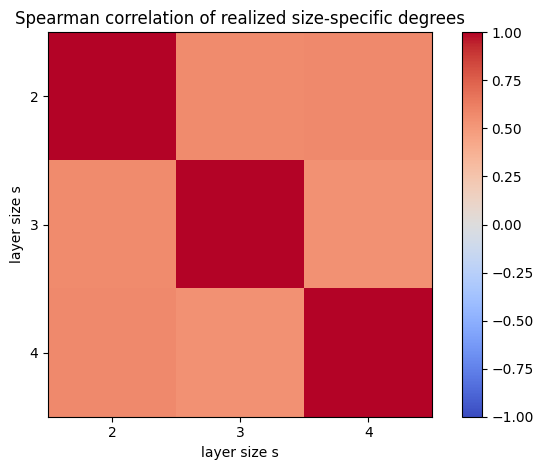

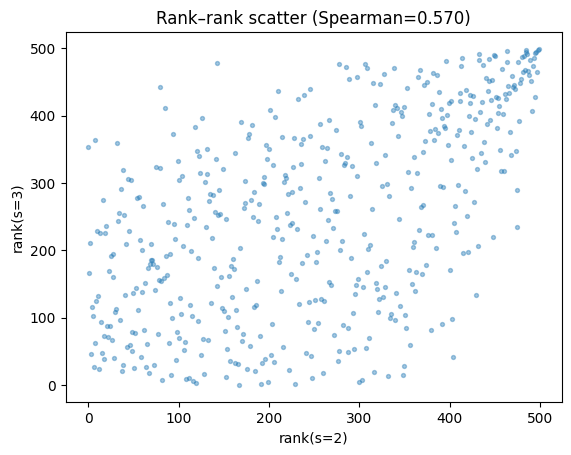

In [39]:
deg = degree_matrix(H, sizes=sorted(edges_by_size.keys()), num_nodes=num_nodes)
sizes, M = spearman_corr_matrix(deg)

print("Spearman correlations of realized degrees:")
for i, si in enumerate(sizes):
    for j, sj in enumerate(sizes):
        if j > i:
            print(f"  s={si} vs s={sj}: {M[i,j]:.3f}")

plot_corr_matrix(sizes, M, title="Spearman correlation of realized size-specific degrees")
plot_rank_scatter(deg[2], deg[3], a_label="s=2", b_label="s=3")


## 3) Degree distributions across layers

A common visualization for heavy-tailed degree distributions is the **CCDF** on log–log axes.
If the generator is behaving as expected, you should see:

- broad/heavy-tailed degree distributions in each layer,
- heavier tails (more extreme hubs) when `alpha_by_size` is larger.


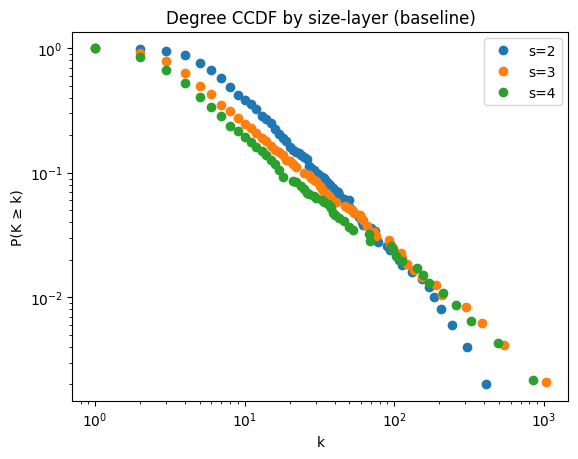

In [40]:
plot_degree_distributions(deg, title="Degree CCDF by size-layer (baseline)")


## 4) Generating a variety of hypergraphs

Below we vary:

- **hub persistence** (`rho`): independent layers (`rho≈0`), aligned hubs (`rho>0`), anti-aligned hubs (`rho<0`);
- **heterogeneity** (`alpha_by_size`): weaker hubs vs stronger hubs;
- **layer-specific heterogeneity**: different `alpha` for each layer.

We track:
- inter-layer Spearman correlations of realized degrees,
- CCDFs per layer.


Case A: Independent layers (rho=0.0)
  alpha_by_size: 1.1  rho: 0.0
    Spearman(k^(s=2), k^(s=3)) = 0.016
    Spearman(k^(s=2), k^(s=4)) = -0.016
    Spearman(k^(s=3), k^(s=4)) = -0.033


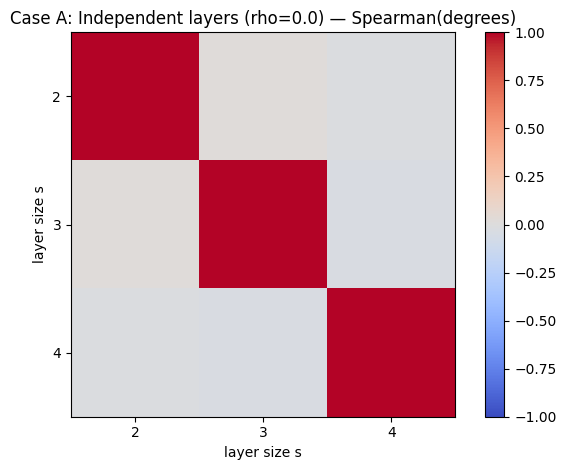

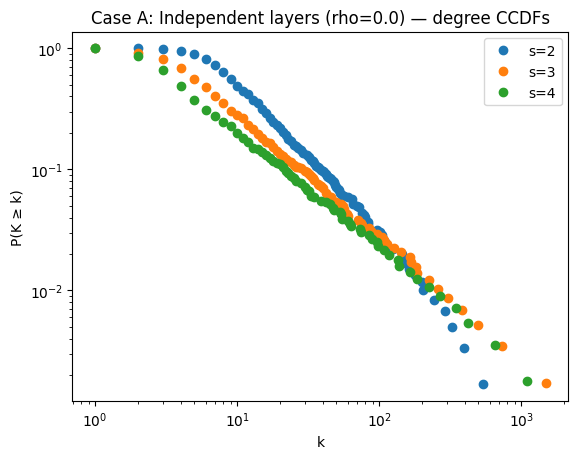

Case B: Strongly aligned hubs (rho=0.85)
  alpha_by_size: 1.1  rho: 0.85
    Spearman(k^(s=2), k^(s=3)) = 0.643
    Spearman(k^(s=2), k^(s=4)) = 0.629
    Spearman(k^(s=3), k^(s=4)) = 0.590


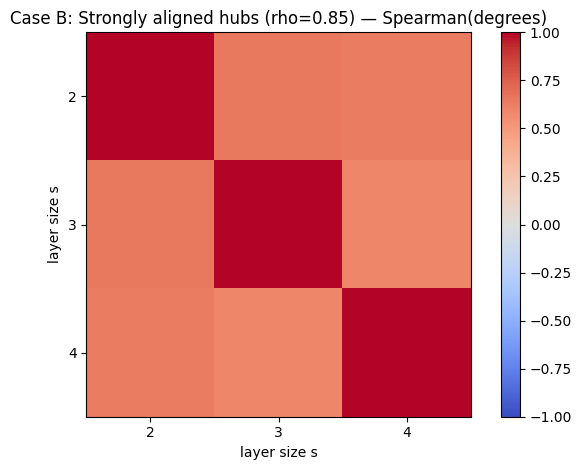

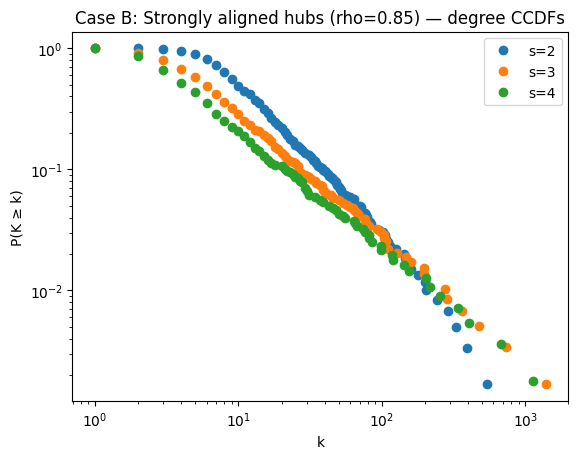

Case C: Anti-aligned hubs (rho=-0.35)
  alpha_by_size: 1.1  rho: -0.35
    Spearman(k^(s=2), k^(s=3)) = -0.269
    Spearman(k^(s=2), k^(s=4)) = -0.268
    Spearman(k^(s=3), k^(s=4)) = -0.181


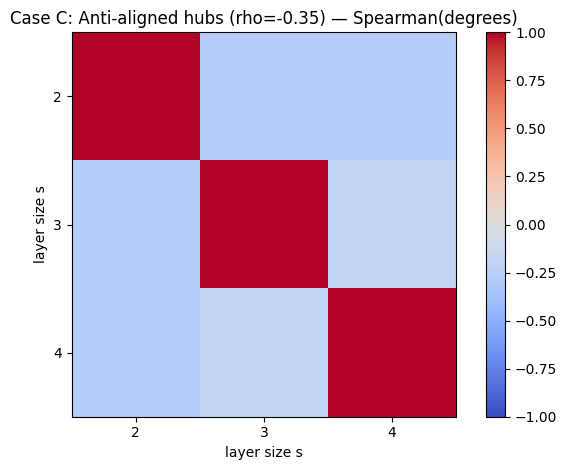

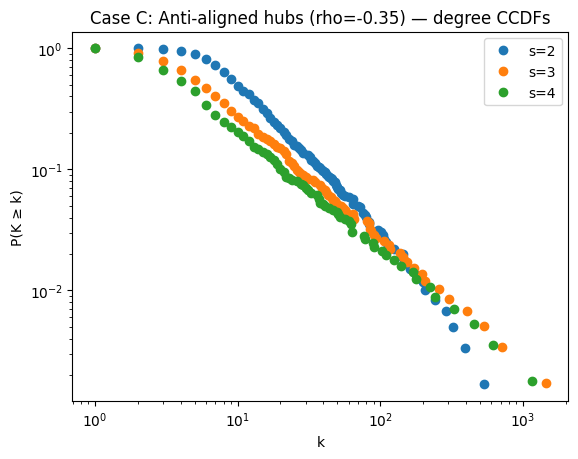

Case D: Layer-dependent heterogeneity (alpha varies by size)
  alpha_by_size: {2: 0.8, 3: 1.1, 4: 1.4}  rho: 0.75
    Spearman(k^(s=2), k^(s=3)) = 0.556
    Spearman(k^(s=2), k^(s=4)) = 0.505
    Spearman(k^(s=3), k^(s=4)) = 0.504


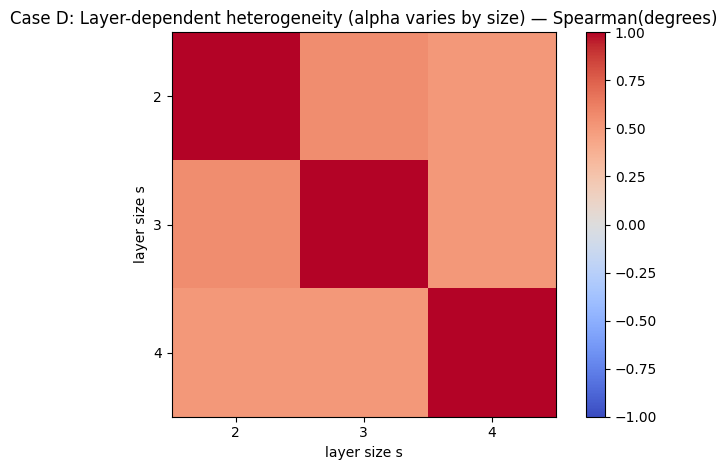

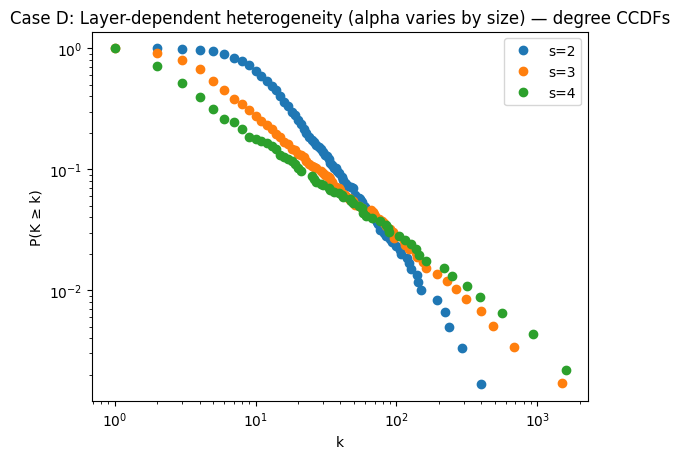

In [41]:
def summarize_hypergraph(num_nodes, edges_by_size, alpha_by_size, rho, seed=0):
    H = scale_free_hypergraph(
        num_nodes=num_nodes,
        edges_by_size=edges_by_size,
        alpha_by_size=alpha_by_size,
        rho=rho,
        seed=seed,
        enforce_unique_edges=True,
    )
    deg = degree_matrix(H, sizes=sorted(edges_by_size), num_nodes=num_nodes)
    sizes, M = spearman_corr_matrix(deg)
    return H, deg, sizes, M

def show_case(title, num_nodes, edges_by_size, alpha_by_size, rho, seed=0):
    H, deg, sizes, M = summarize_hypergraph(num_nodes, edges_by_size, alpha_by_size, rho, seed=seed)
    print(title)
    print("  alpha_by_size:", alpha_by_size, " rho:", rho)
    for i, si in enumerate(sizes):
        for j, sj in enumerate(sizes):
            if j > i:
                print(f"    Spearman(k^(s={si}), k^(s={sj})) = {M[i,j]:.3f}")
    plot_corr_matrix(sizes, M, title=f"{title} — Spearman(degrees)")
    plot_degree_distributions(deg, title=f"{title} — degree CCDFs")
    return H, deg, sizes, M

num_nodes = 600
edges_by_size = {2: 6000, 3: 3500, 4: 2000}
seed = 11

# 4.1 Independent layers (rho ~ 0)
_ = show_case(
    title="Case A: Independent layers (rho=0.0)",
    num_nodes=num_nodes,
    edges_by_size=edges_by_size,
    alpha_by_size=1.1,
    rho=0.0,
    seed=seed,
)

# 4.2 Strongly aligned hubs (rho > 0)
_ = show_case(
    title="Case B: Strongly aligned hubs (rho=0.85)",
    num_nodes=num_nodes,
    edges_by_size=edges_by_size,
    alpha_by_size=1.1,
    rho=0.85,
    seed=seed,
)

# 4.3 Anti-aligned hubs (rho < 0) within feasibility bound:
# With 3 layers, rho >= -1/(3-1) = -0.5
_ = show_case(
    title="Case C: Anti-aligned hubs (rho=-0.35)",
    num_nodes=num_nodes,
    edges_by_size=edges_by_size,
    alpha_by_size=1.1,
    rho=-0.35,
    seed=seed,
)

# 4.4 Layer-dependent heterogeneity (different alpha per layer)
_ = show_case(
    title="Case D: Layer-dependent heterogeneity (alpha varies by size)",
    num_nodes=num_nodes,
    edges_by_size=edges_by_size,
    alpha_by_size={2: 0.8, 3: 1.1, 4: 1.4},
    rho=0.75,
    seed=seed,
)


## 5) Hub overlap across layers (optional visualization)

Another intuitive diagnostic is how much the **top-q% hubs** overlap across layers.

We compute, for each pair of layers, the Jaccard similarity between the sets of top hubs
(according to size-specific degree).


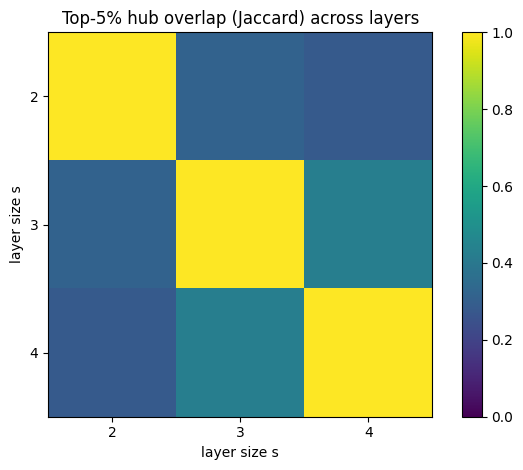

In [42]:
def top_hubs(deg, q=0.05):
    n = len(deg)
    k = max(1, int(round(q * n)))
    return set(np.argsort(deg)[-k:])

def hub_overlap_matrix(deg_by_size: dict[int, np.ndarray], q=0.05):
    sizes = sorted(deg_by_size.keys())
    M = np.zeros((len(sizes), len(sizes)), dtype=float)
    tops = {s: top_hubs(deg_by_size[s], q=q) for s in sizes}
    for i, si in enumerate(sizes):
        for j, sj in enumerate(sizes):
            A, B = tops[si], tops[sj]
            M[i, j] = len(A & B) / len(A | B)
    return sizes, M

# Using the last case generated above (Case D) if variables exist; otherwise recompute quickly.
try:
    deg_last = deg
except NameError:
    H_tmp = scale_free_hypergraph(
        num_nodes=600, edges_by_size={2: 6000, 3: 3500, 4: 2000},
        alpha_by_size=1.1, rho=0.75, seed=0
    )
    deg_last = degree_matrix(H_tmp, sizes=[2,3,4], num_nodes=600)

sizes_h, J = hub_overlap_matrix(deg_last, q=0.05)
plot_corr_matrix(sizes_h, J, title="Top-5% hub overlap (Jaccard) across layers", vmin=0.0, vmax=1.0, cmap="viridis")


## Notes / troubleshooting

- If your realized degree correlations look noisy, increase `edges_by_size` (more hyperedges per layer).
- Very large `alpha` can produce extremely dominant hubs (almost a star-like structure).
- Negative `rho` is constrained when you have many sizes because the **equicorrelation matrix**
  must be a valid covariance/correlation matrix (PSD). With `m` sizes, the bound is \(\rho \ge -1/(m-1)\).
